In [11]:
# Figure S7``

In [12]:
import re
import warnings

import cmaps 
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from gcpy import single_panel 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np 
import regionmask
import scipy.stats as stats
from scipy.stats import gmean, gstd
import seaborn as sns 
import xarray as xr 

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Define variable of interest (here, biog. isoprene)
variable = "EmisISOP_Biogenic"
variable_string = "Biogenic isoprene emissions"
# 1000g/kg * (60.06/68.12) kgC/kgISOP * 86400 s/day * 153 April-August days/year
conversion_factor = 1000 * (60.06/68.12)  * 86400 * (153)

# Load original simulations
ref = tools.get_original_values(variable, "all_ref_c48", conversion_factor=conversion_factor, resolution='c48')
refshort = tools.get_original_values(variable, "all_refshort_c48", conversion_factor=conversion_factor, resolution='c48')

# Load sensitivity simulations
simulation = "w10_ref_c48_noCO2effect"
year = 2000
ref_isop = tools.get_sensitivity_values(variable, simulation, year=year, conversion_factor=conversion_factor, resolution='c48')

simulation = "w10_refshort_c48_noCO2effect"
year = 2080
refshort_isop = tools.get_sensitivity_values(variable, simulation, year=year, conversion_factor=conversion_factor, resolution='c48')

In [14]:
# Dictionary of datasets
datasets = {
    "ref": {
        "data": ref,
        "resolution": 'c48'
        
    },
    "refshort": {
        "data": refshort,
        "resolution": 'c48'
    },
    "refisop": {
        "data": ref_isop,
        "resolution": 'c48'
        
    },
    "refshortisop": {
        "data": refshort_isop,
        "resolution": 'c48'
    }
}

comparison_months = [4,5,6,7,8]
regions = ["ENA", "WCE", "EAS"]

# Store regional mean and stdev in "results"
results = {}
for ds_name, ds_info in datasets.items():
    ds_data = ds_info["data"]
    ds_resolution = ds_info["resolution"]
    results[ds_name] = {}
    for region in regions:
        result_key = f"{region}"  # e.g. "ENA"
        results[ds_name][result_key] = tools.calculate_regional_mean_std(
                ds_data, comparison_months, region, resolution=ds_resolution
            )

In [15]:
# Define helper functions to access results
def extract_means(dataset_name):
    """Returns a tuple of mean values (index=0) for each region."""
    return tuple(results[dataset_name][f"{region}"][0] for region in regions)

def extract_stds(dataset_name):
    """Returns a tuple of std values (index=1) for each region."""
    return tuple(results[dataset_name][f"{region}"][1] for region in regions)

In [16]:
# Part 1: Regional Biogenic Isoprene Comparison: baseline vs noCO2effect
ref_mean = extract_means("ref")
refshort_mean = extract_means("refshort")

refisop_mean = extract_means("refisop")
refshortisop_mean = extract_means("refshortisop")

ref_std  = extract_stds("ref")
refshort_std  = extract_stds("refshort")

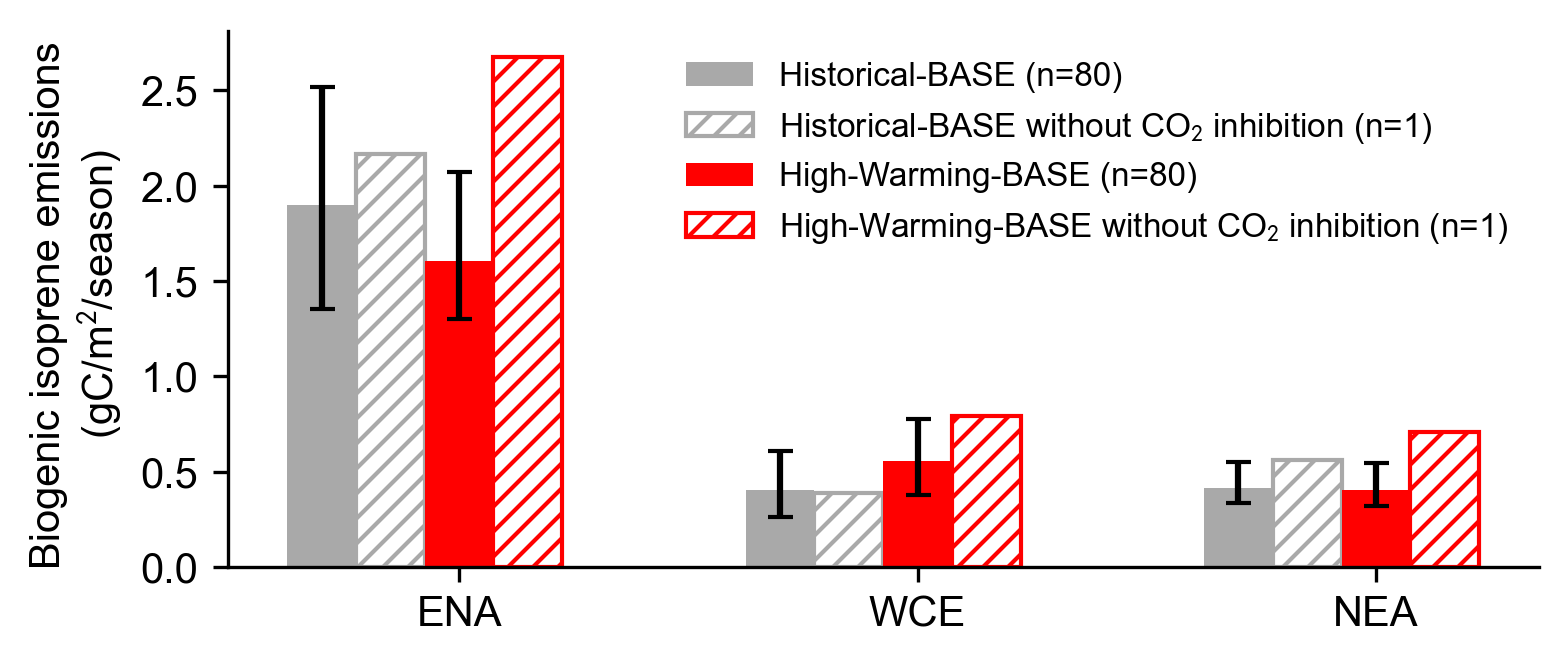

In [17]:
bar_width = 0.15 
categories = ['ENA', 'WCE', 'NEA']
x = np.arange(len(categories))

tools.set_matplotlib_font("Arial")
mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 10, 
    'axes.titlesize': 10, 
    'axes.labelsize': 10,
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})


fig = plt.figure(figsize=(5.33, 2.15), dpi=300)
gs1 = GridSpec(1, 1, top=0.95, bottom=0.12, left=0.15, right=0.97, hspace=0.50, wspace=0.4)
axes = fig.add_subplot(gs1[0, 0])

# Part 1: Regional Mean Ozone Response Comparison: baseline vs noCO2effect
axes.bar(x - 2*bar_width, ref_mean, bar_width, yerr=tools.reshape_data(ref_std),      capsize=3, label="Historical-BASE (n=80)", color="darkgray", lw=0.5)
axes.bar(x - bar_width,   refisop_mean, bar_width, label="Historical-BASE without CO$_2$ inhibition (n=1)", color="white", hatch='////', edgecolor="darkgray")
axes.bar(x,   refshort_mean,    bar_width, yerr=tools.reshape_data(refshort_std), capsize=3, label="High-Warming-BASE (n=80)", color="red")
axes.bar(x + bar_width, refshortisop_mean, bar_width, label="High-Warming-BASE without CO$_2$ inhibition (n=1)", color="white", hatch='////', edgecolor="red")

# Axis settings
axes.set_ylabel(f"{variable_string} \n (gC/m$^2$/season)", fontsize=10)
axes.spines[['right', 'top']].set_visible(False)
axes.legend(fontsize=8, frameon=False, loc='upper right')
plt.xticks(x, categories, fontsize=10)

#############################################
plt.savefig("FigS7_new.png")

In [18]:
# Calculate percentage increase in isoprene emissions with/without CO2 effect (reported in Section 3.6) 

# Step 1: WITH CO2 effect
first = ref_mean
second = refshort_mean

percentage_increase = tuple(
    ((new - old) / old * 100) for old, new in zip(first, second)
)
absolute_increase = tuple(
    (new - old) for old, new in zip(first, second)
)

print("Percentage increases (in %):", percentage_increase)
print("Absolute increases (in K):", absolute_increase)

print("Percentage increases (in %):", tuple("{:.2g}".format(x) for x in percentage_increase))
print("Absolute increases (in K):", tuple("{:.2g}".format(x) for x in absolute_increase))

# Step 2: WITHOUT CO2 effect
first = refisop_mean
second = refshortisop_mean

percentage_increase = tuple(
    ((new - old) / old * 100) for old, new in zip(first, second)
)
absolute_increase = tuple(
    (new - old) for old, new in zip(first, second)
)

print("Percentage increases (in %):", percentage_increase)
print("Absolute increases (in K):", absolute_increase)

print("Percentage increases (in %):", tuple("{:.2g}".format(x) for x in percentage_increase))
print("Absolute increases (in K):", tuple("{:.2g}".format(x) for x in absolute_increase))



Percentage increases (in %): (-15.68005084991455, 38.416582345962524, -1.8255358561873436)
Absolute increases (in K): (-0.2981193, 0.15438282, -0.007531166)
Percentage increases (in %): ('-16', '38', '-1.8')
Absolute increases (in K): ('-0.3', '0.15', '-0.0075')
Percentage increases (in %): (23.622648417949677, 104.32158708572388, 26.708313822746277)
Absolute increases (in K): (0.51126456, 0.40399462, 0.14963692)
Percentage increases (in %): ('24', '1e+02', '27')
Absolute increases (in K): ('0.51', '0.4', '0.15')
